# Solvent-targeted plastic dissolution and precipitation (STRAP)

## Basics
It is often said that we live in the plastics age. Plastics are consumed across all sectors (clothing, medicine, construction, food packaging) as plastics are versatile, low cost, and easy to manufacture. However, the final disposal of plastics is a global concern. Multilayer films are among the most challenging plastic wastes to recycle, but the STRAP technology can recover the individual plastic components, known as resins. STRAP “washes” multilayered films several times with solvents to separate each resin at a time. These resins can then be reused to make more of the product from which they originated, or they can be used to manufacture products with higher value or quality (known as upcycling).

## Process configuration
We will be looking at a STRAP process model for the separation of post-industrial multilayered plastic film composed of PE, EvOH, and PET (Figure 1). Many uncertainties exist for this emerging technology, such as the relative amount PE in the film and the amount of solvent required to dissolve it. 

![STRAP-B](./STRAP_overview.png)

A preliminary STRAP process model was developed in BioSTEAM with roughly the flowsheet configuration shown in Figure 2. Note that the flowsheet shows only one cycle of a dissolution and precipitation step, but two cycles are needed to separate all components (PE, EvOH, PET).

![STRAP-B](./STRAP_flowsheet.png)

We will push and pull the BioSTEAM model to understand the economic and environmental impact of the mass fraction of PE in the plastic waste and the dissolution capacity of the solvent.

## BioSTEAM model
First let's load the process model:

In [2]:
import biosteam as bst
from plastics import strap
bst.nbtutorial() # enable interactive diagrams
model = strap.BaselineSTRAPModel()
model.system.diagram()

Every unit operation and stream are available as attributes in the model:

In [3]:
model.U3.show('cwt')

BatchPlasticDissolution: U3
ins...
[0] s3  from  ConveyingBelt-U2
    phase: 'l', T: 298.15 K, P: 101325 Pa
    composition (%): PE    30
                     PET   67.7
                     EVOH  2.33
                     ----  4.44e+04 kg/hr
[1] s10  from  HXutility-H1
    phase: 'l', T: 324.97 K, P: 1.01325e+06 Pa
    composition (%): Toluene     99.9
                     PEoligomer  0.0929
                     ----------  2.47e+05 kg/hr
outs...
[0] s11  to  StorageTank-T4
    phase: 'l', T: 321.87 K, P: 101325 Pa
    composition (%): Toluene     84.7
                     PEoligomer  4.66
                     PET         10.3
                     EVOH        0.356
                     ----------  2.91e+05 kg/hr


In [4]:
model.U3.results()

Batch plastic dissolution                      Units                   U3
Electricity         Power                         kW                  163
                    Cost                      USD/hr                 11.4
Design              Reactor volume                m3                  207
                    Residence time                hr                  0.5
                    Vessel type                                  Vertical
                    Length                        ft                 43.8
                    Diameter                      ft                 14.6
                    Weight                        lb             4.82e+04
                    Wall thickness                in                 0.49
                    Vessel material                   Stainless steel 304
Purchase cost       Vertical pressure vessel     USD             3.19e+05
                    Platform and ladders         USD             6.19e+04
                    Agitator - Agitator          USD             1.28e+05
Total purchase cost                              USD             5.09e+05
Utility cost                                  USD/hr                 11.4

The model also exposes key parameters you can modify and system-wide metrics you can compute:

In [5]:
model.show()

ProcessModel:
parameters: Feedstock - Price [USD/kg]
            Solvent - Price [USD/kg]
            IRR [%]
            Polymer - Mass fraction
            Centrifuged plastic - Solvent content [%]
            Centrifuged precipitate - Solvent content [%]
            Screw pressed precipitate - Solvent content [%]
            Solvent - Normal boiling point [K]
            Dissolution - Temperature [K]
            Precipitation - Temperature drop [%]
            Dissolution - Solvent capacity [wt %]
metrics: Product - GWP [kg*CO2e/kg]
         MSP [USD/kg]


In [6]:
model.MSP(), model.GWP() # Get minimum selling price and carbon intensity

(0.09082390147091168, 0.029677590599472288)

In [7]:
model.set_mass_fraction(0.4) # Set PE fraction
model.system.simulate() # Rerun system
model.MSP(), model.GWP() # Get minimum selling price and carbon intensity

(0.0954855085784867, 0.03385677041752688)

## Sensitivity analysis

Now that we understand the model, we can evaluate it across potential scenarios to understand the impact of the plastic composition and solvent dissolution capacity.

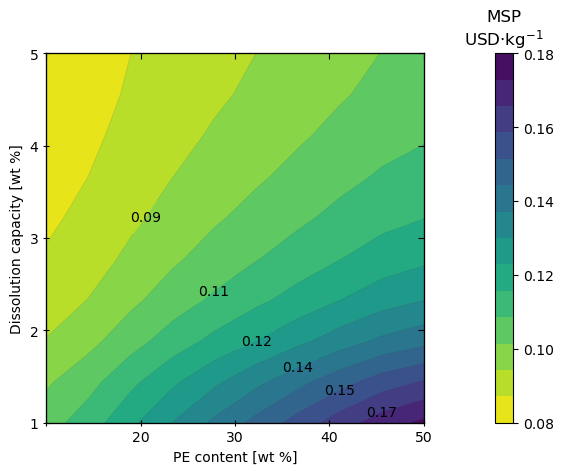

In [8]:
import numpy as np
from matplotlib import pyplot as plt

def MSP_at_PE_mass_fraction_and_dissolution_capacity(mass_fraction, dissolution_capacity):
    model.set_mass_fraction(mass_fraction)
    model.set_dissolution_capacity(dissolution_capacity)
    model.system.simulate()
    return model.MSP()

xlim = np.array([0.1, 0.5])
ylim = np.array([1, 5])
X, Y, Z = bst.plots.generate_contour_data(
    MSP_at_PE_mass_fraction_and_dissolution_capacity,
    xlim=xlim, ylim=ylim,
    n=10,
)

# Plot contours
xlabel = "PE content [wt %]"
ylabel = 'Dissolution capacity [wt %]'
xticks = [10, 20, 30, 40, 50]
yticks = [1, 2, 3, 4, 5]
metric_bar = bst.plots.MetricBar(
    'MSP', 'USD$\cdot$kg$^{-1}$', plt.cm.get_cmap('viridis_r'), 
    [0.08, 0.10, 0.12, 0.14, 0.16, 0.18], 15, 2
)
fig, axes, CSs, CB, other_axes = bst.plots.plot_contour_single_metric(
    100 * X, Y, Z[:, :, None, None], xlabel, ylabel, xticks, yticks, metric_bar,  
    fillcolor=None, styleaxiskw=dict(xtick0=False), label=True,
)